In [10]:
import pandas as pd
df = pd.read_parquet("../parquets/detection_results_validation.parquet")

In [11]:
df

,filename,classid,score,x1,y1,x2,y2
0,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.401814,121,256,162,285
1,/workspace/yolo_v8_training/oiv7_full/validati...,2,0.500673,158,360,259,422
2,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.931938,349,5,698,613
3,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.914084,9,94,328,589
4,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.865071,693,156,1017,884
...,...,...,...,...,...,...,...
113237,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.793295,305,244,358,325
113238,/workspace/yolo_v8_training/oiv7_full/validati...,2,0.568887,318,348,349,389
113239,/workspace/yolo_v8_training/oiv7_full/validati...,3,0.450863,312,277,344,319
113240,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.414001,724,468,765,548


In [12]:
df.dropna(inplace=True) # Visualize outliers

In [13]:
# Convert cxcywh to xyxy
df['x1'] = df['col_x'] - df['width'] / 2
df['y1'] = df['row_y'] - df['height'] / 2
df['x2'] = df['col_x'] + df['width'] / 2
df['y2'] = df['row_y'] + df['height'] / 2

df = df[['score', 'x1', 'y1', 'x2', 'y2', 'label', 'filename']]

KeyError: 'col_x'

In [ ]:
grouped_df = df.groupby('filename')

In [ ]:
agg_df = grouped_df.agg(lambda x: list(x))
agg_df = agg_df.reset_index()

In [14]:
agg_df

,filename,score,x1,y1,x2,y2,label
0,/workspace/yolo_v8_training/oiv7_full/train/00...,[0.6233760118484497],[658.0],[347.0],[705.0],[404.0],[person]
1,/workspace/yolo_v8_training/oiv7_full/train/00...,[0.5191749334335327],[198.0],[239.0],[502.0],[485.0],[person]
2,/workspace/yolo_v8_training/oiv7_full/train/00...,[0.7600982189178467],[356.0],[133.0],[768.0],[448.0],[person]
3,/workspace/yolo_v8_training/oiv7_full/train/00...,[0.5055577158927917],[388.0],[473.0],[466.0],[575.0],[person]
4,/workspace/yolo_v8_training/oiv7_full/train/00...,[0.6864570379257202],[0.0],[123.0],[404.0],[323.0],[person]
...,...,...,...,...,...,...,...
373,/workspace/yolo_v8_training/oiv7_full/train/13...,[0.3720417022705078],[0.0],[0.0],[344.0],[404.0],[person]
374,/workspace/yolo_v8_training/oiv7_full/train/13...,[0.37520071864128113],[366.0],[339.0],[615.0],[547.0],[person]
375,/workspace/yolo_v8_training/oiv7_full/train/13...,[0.45324641466140747],[616.0],[328.0],[687.0],[410.0],[person]
376,/workspace/yolo_v8_training/oiv7_full/train/13...,[0.49255993962287903],[255.0],[9.0],[749.0],[442.0],[person]


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def generate_colormap(labels, hue_start=0.1, hue_end=0.9, saturation=0.9, value=0.8):
    """
    Generate a colormap for a set of unique labels while avoiding bright colors.

    Parameters:
        labels (iterable): An iterable object containing labels.
        hue_start (float): The start value of the hue range in HSV space.
        hue_end (float): The end value of the hue range in HSV space.
        saturation (float): Saturation level to set for the colors.
        value (float): Brightness level to set for the colors.

    Returns:
        dict: A dictionary mapping labels to colors in RGB format.
    """
    try:
        from matplotlib.colors import hsv_to_rgb
    except:
        print("matplotlib dependency is needed please install using pip3 install matplotlib")
        raise

    unique_labels = set(labels)
    n_labels = len(unique_labels)

    # Define ranges for Hue
    hue_range = np.linspace(hue_start, hue_end, n_labels)

    # Create colormap in HSV and then convert to RGB
    colormap_hsv = np.zeros((n_labels, 3))
    colormap_hsv[:, 0] = hue_range
    colormap_hsv[:, 1] = saturation
    colormap_hsv[:, 2] = value
    colormap = [hsv_to_rgb(color) for color in colormap_hsv]

    # Create a label to color mapping
    label_to_color = {label: colormap[i] for i, label in enumerate(unique_labels)}

    return label_to_color
    
def annotate_image(ax, img, annotations):
    ax.imshow(img)
    label_to_color = generate_colormap(annotations["labels"])

    for label, score, box in zip(annotations["labels"], annotations["scores"], annotations["boxes"]):
        x1, y1, x2, y2 = box
        color = label_to_color.get(label, (0, 0, 0, 1))  # Fallback color is black
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label} | {score:.2f}", fontsize=10, color="white",
                bbox=dict(facecolor=color, edgecolor=color, boxstyle="round,pad=0.5"))

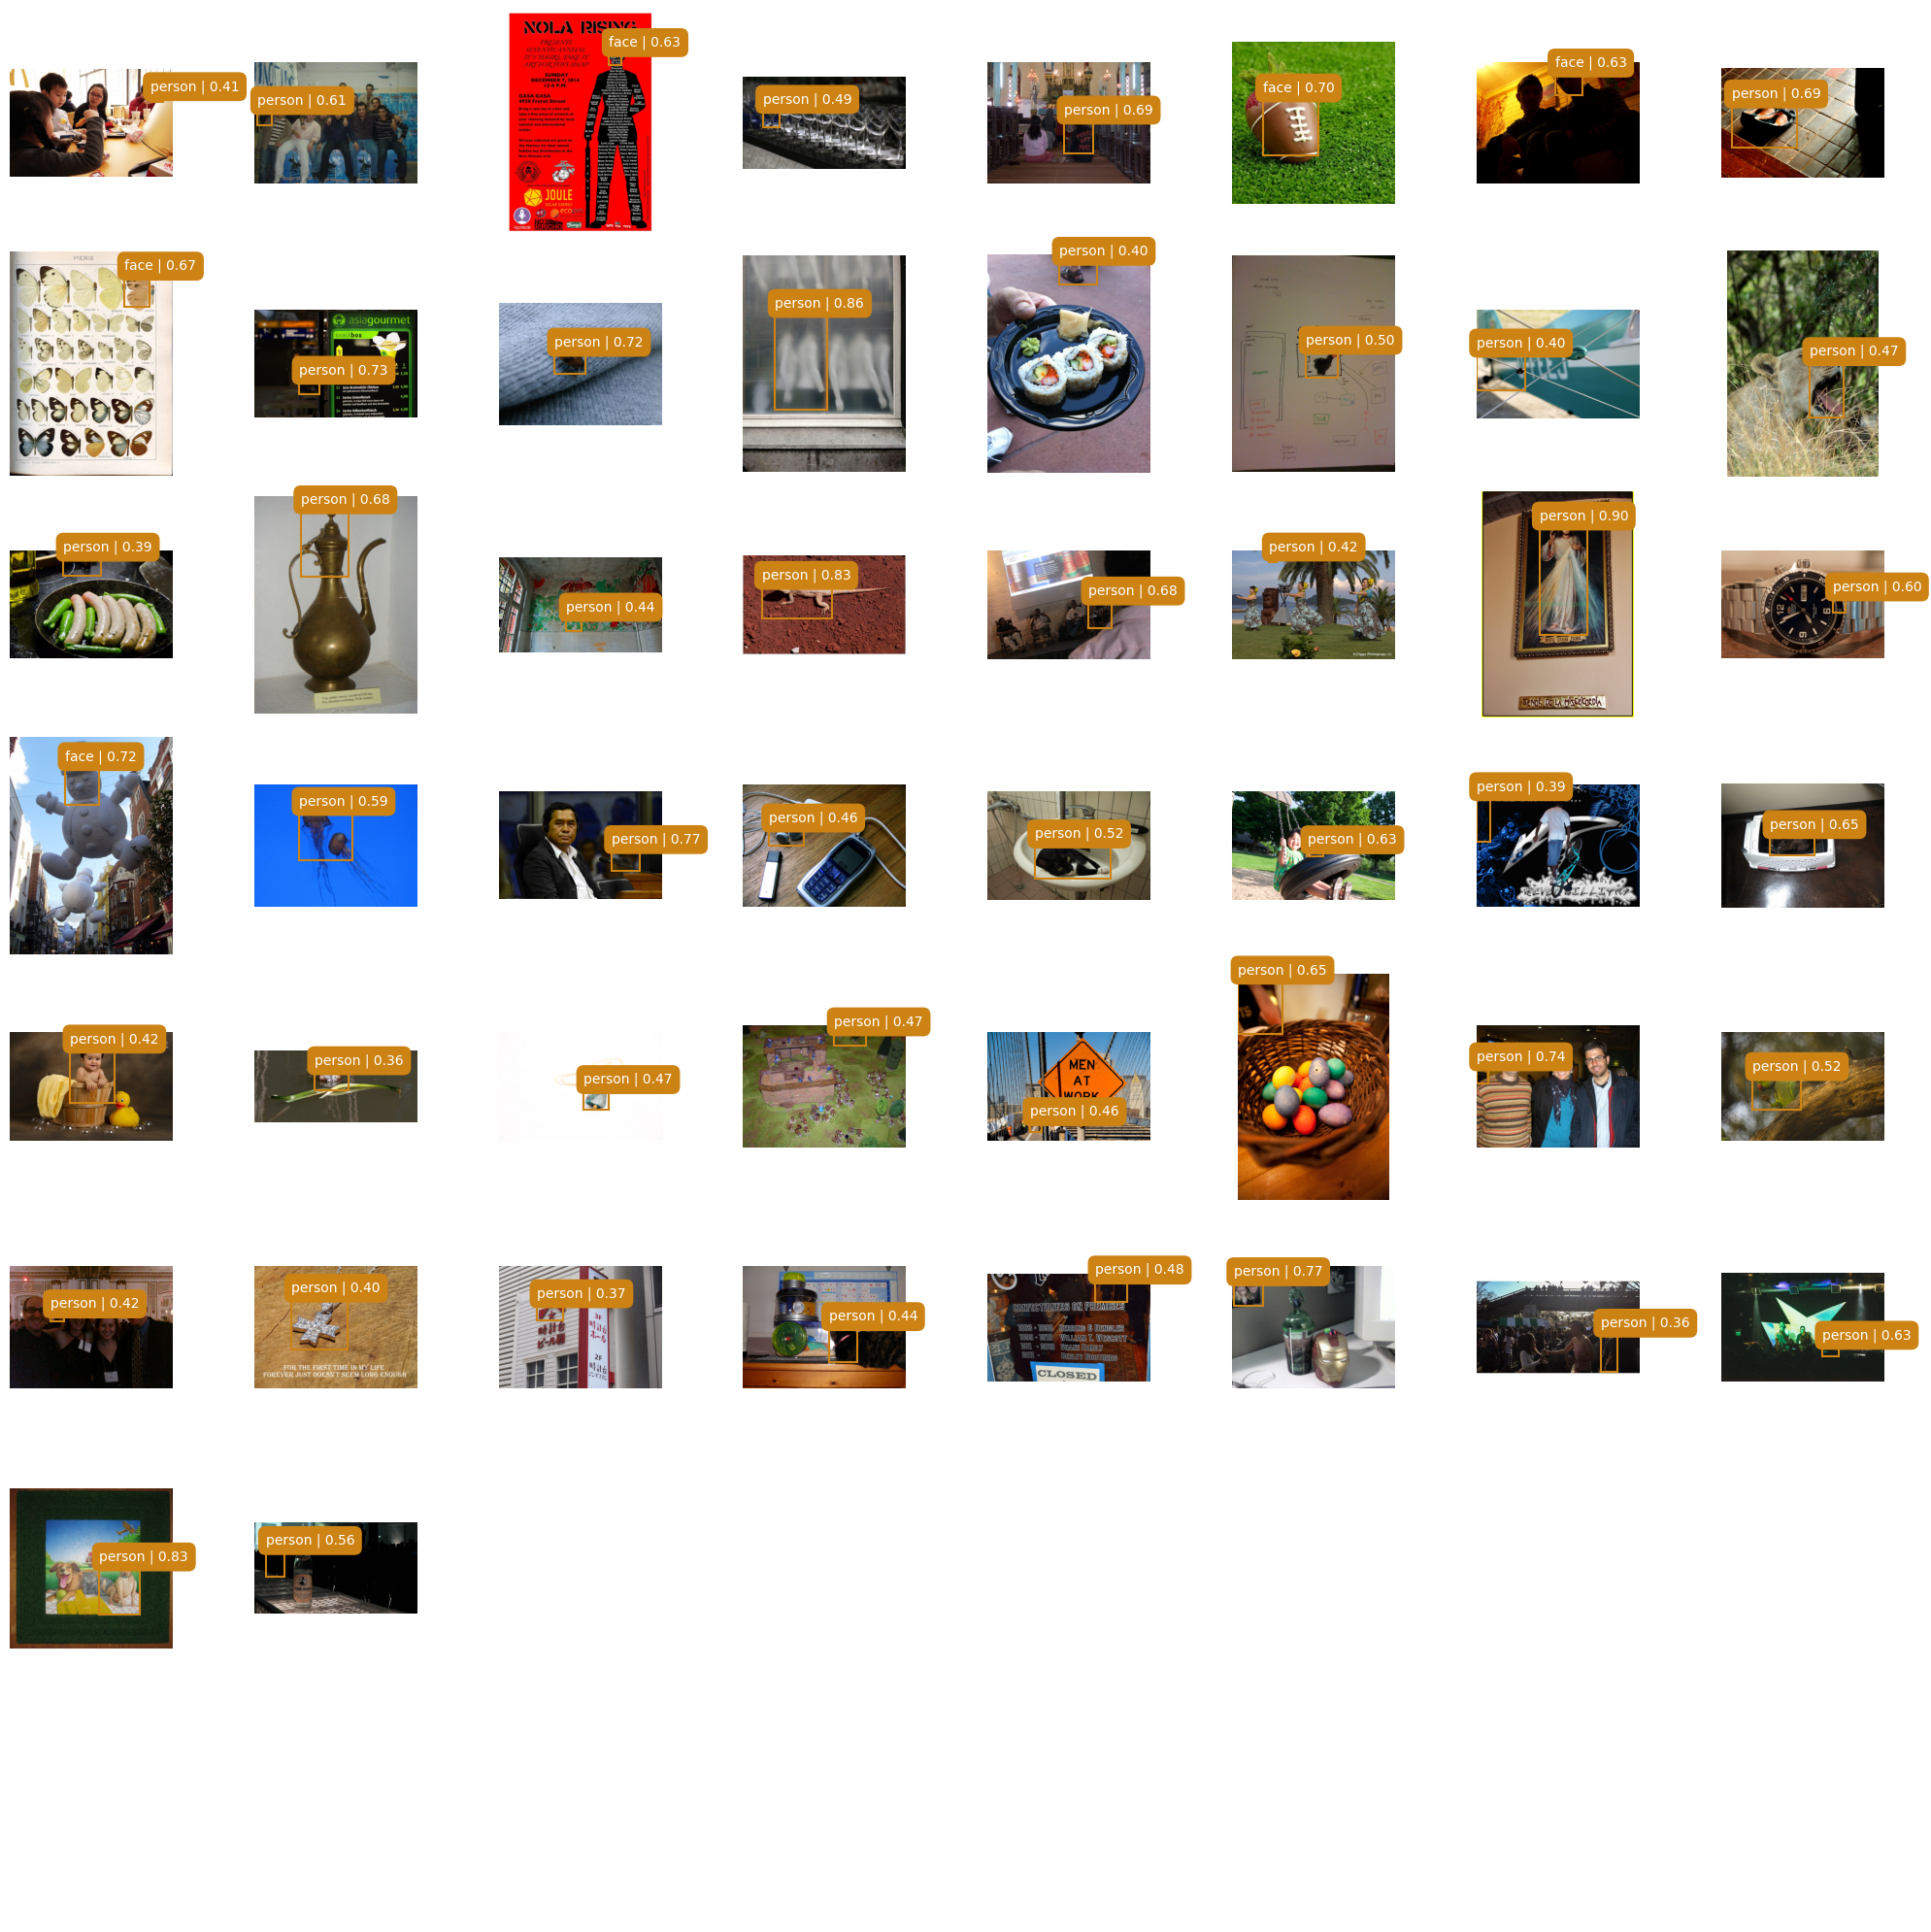

In [16]:
NUM_IMAGES = 50
sampled_df = agg_df.sample(NUM_IMAGES) 

# Calculate grid size
n_images = len(sampled_df)
grid_size = int(n_images**0.5) + 1  # Simple way to determine grid size

# Create figure and axes
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

axes = axes.flatten()  # Flatten to easily iterate over

for ax, (index, row) in zip(axes, sampled_df.iterrows()):
    filename = row['filename']
    img = plt.imread(filename)  # Assuming plt is imported from matplotlib
    annotations = {
        'labels': row['label'],
        'scores': row['score'],
        'boxes': list(zip(row['x1'], row['y1'], row['x2'], row['y2']))
    }
    
    annotate_image(ax, img, annotations)
    ax.axis('off')  # Hide axis

# Hide any unused subplots
for ax in axes[len(sampled_df):]:
    ax.axis('off')
    
plt.tight_layout()
plt.show()